In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import pickle

In [2]:
movielibrary = pickle.load(open("BoxOfficeMojo_df.p", "rb"))

In [3]:
weeklies = pickle.load(open("Weeklies_BoxOfficeMojo_df.p", "rb"))

In [19]:
imdb = pickle.load(open("IMDB_df.p", "rb"))

In [652]:
names = set(movielibrary["Name"])
weekly_names = set(weeklies["Name"])
print(len(names))
print(len(weekly_names))

5190
5148


In [401]:
weeklies.columns

Index(['Name', 'Peak', 'REAL name', 'Date', 'Rank', 'Weekly', '%LW',
       'Theaters', 'Change', 'Avg', 'To Date', 'Week', 'Estimated',
       'In Theaters', 'Weeks of Data', 'Decay to-date', 'Log Decay',
       'Log Week', 'Log Decay as weekly', 'Decay inverse', 'Complete Data',
       'Week_of_Year'],
      dtype='object')

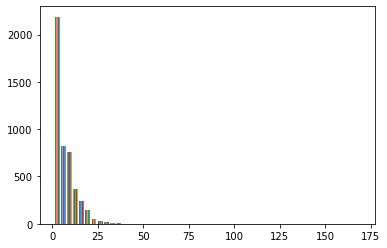

In [430]:
import matplotlib.pyplot as plt
cutoff = 700
above_cutoff = weeklies["Avg"]>cutoff
how_many_weeks = weeklies[above_cutoff].groupby("REAL name").count()
plt.hist(how_many_weeks, bins=50);
#how_many_weeks

I'm functionally working with count data, unfortunately, due to the metric I've chosen.

In [431]:
import seaborn as sns

In [882]:
def df_above_cutoff(cutoff, df, min_weeks):
    """
    Identifies the target variable, "number of weeks for which the average box office was above a target variable."
    Screens out movies for which there are less than min_weeks of data.
    
    """
    compiled_weeklies = []
    for name in set(df["Name"]):
        movie_df = df[df["Name"]==name]
        if(movie_df["Avg"].count()>=min_weeks):
            fake_name = name


            real_name = movie_df["REAL name"].iloc[0]
            
            #Added 1 to allow boxcox to function if the movie never was above the cutoff in any week.
            num_above_cutoff = (movie_df["Avg"]>cutoff).sum()+1

            first_week = movie_df["Week"].min()

            first_two_weeks = movie_df[movie_df["Week"]<=1+first_week]
            theaters_in_two_weeks = first_two_weeks["Theaters"].max().replace(",","")
            if theaters_in_two_weeks == "-":
                theaters_in_two_weeks = None
            else:
                theaters_in_two_weeks = int(theaters_in_two_weeks)
            avg_BO_two_weeks_sum = first_two_weeks["Avg"].sum()

            compiled_weeklies.append([fake_name, real_name, num_above_cutoff, theaters_in_two_weeks, avg_BO_two_weeks_sum])
    return pd.DataFrame(data=compiled_weeklies, columns=["REAL name", "Name", "Weeks Until Dropoff", "2 wk Theaters", "2 wk Box Office"])


#Metric selected so that on average, movies drop below the dropoff after 8 weeks. 
weeks_to_dropoff_df = df_above_cutoff(800, weeklies, 4)

In [883]:
merged = weeks_to_dropoff_df.merge(movielibrary, how="left").merge(imdb, how="left")

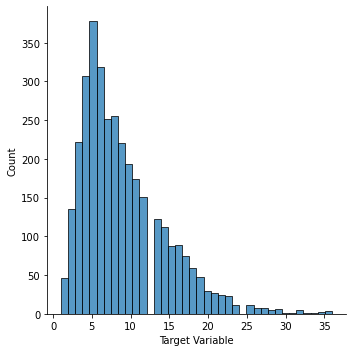

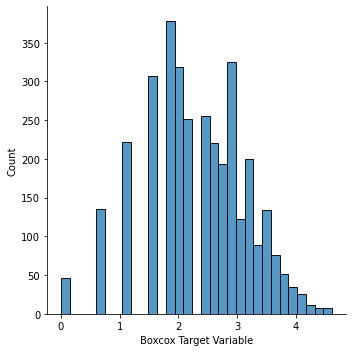

In [897]:
sns.displot(data=merged[merged["Weeks Until Dropoff"]<40], x="Weeks Until Dropoff")

#That looks skewed. Let's fix that. 

import scipy.stats as scp
merged["Boxcox Weeks Until Dropoff"], lamb = scp.boxcox(merged["Weeks Until Dropoff"])
sns.displot(data=merged[merged["Weeks Until Dropoff"]<40], x="Boxcox Weeks Until Dropoff")

In [894]:
#8.1 weeks, once I cancel out the adjustment I made to get boxcox working.
merged["Weeks Until Dropoff"].mean()-1

9.118490345231129

In [895]:
#Looking for na values.
merged.count()

REAL name                  3418
Name                       3418
Target Variable            3418
2 wk Theaters              3416
2 wk Box Office            3418
index                      3289
Budget                      773
MPAA                       1942
Genres                     3289
Domestic Opening              0
Running Time               3284
                           3289
Action                     3289
Adult                      3289
Adventure                  3289
Animation                  3289
Biography                  3289
Comedy                     3289
Crime                      3289
Documentary                3289
Drama                      3289
Family                     3289
Fantasy                    3289
Film-Noir                  3289
History                    3289
Horror                     3289
Music                      3289
Musical                    3289
Mystery                    3289
News                       3289
Reality-TV                 3289
Romance 

In [898]:
#Dropping data that was processed into dummies, had very few not-NA values, or just not relevant at this time. Some might return if needed.
merged_clean = merged[merged["Weeks Until Dropoff"]<30].drop(columns=["Genres", "REAL name", "Name", "Running Time", "MPAA", "Budget", "", "M/PG", "Domestic Opening", "Budget"])

#We don't need the actual Target Variable now. 
merged_clean.drop(columns=["Weeks Until Dropoff"])


#These may be used later, if improvement is needed.
merged_clean.drop(columns=["Director", "Cast"], inplace=True)

#removed due to feature engineering
merged_clean.drop(columns=["Short", "Sport", "R", "Adult", "Film-Noir", "Reality-TV"], inplace=True)

#removed due to feature engineering
merged_clean["Family Friendly"] = (merged_clean["Family"]+merged_clean["Fantasy"])>0
merged_clean.drop(columns=["Family", "Fantasy"], inplace=True)

#Small number of these None values, small enough to fill. 
merged_clean["2 wk Theaters"].fillna(merged_clean["2 wk Theaters"].mean(), inplace=True)
merged_clean.dropna(inplace=True)

#Cleaning the string. 
merged_clean["IMDB's Budget"]=merged_clean["IMDB's Budget"].apply(lambda x: int(x.strip()))

#For use in polynomial regression.
merged_clean["Inverse IMDB's Budget"]=1/merged_clean["IMDB's Budget"]


#Unfortunately impossible to use this; the year is cyclic, with pulses at irregular times of the year 
#(i.e. not evenly spaced.)
#Using dummy variables for months kept the model from converging.

merged_clean.drop(columns=["Release Date"], inplace=True)

<AxesSubplot:>

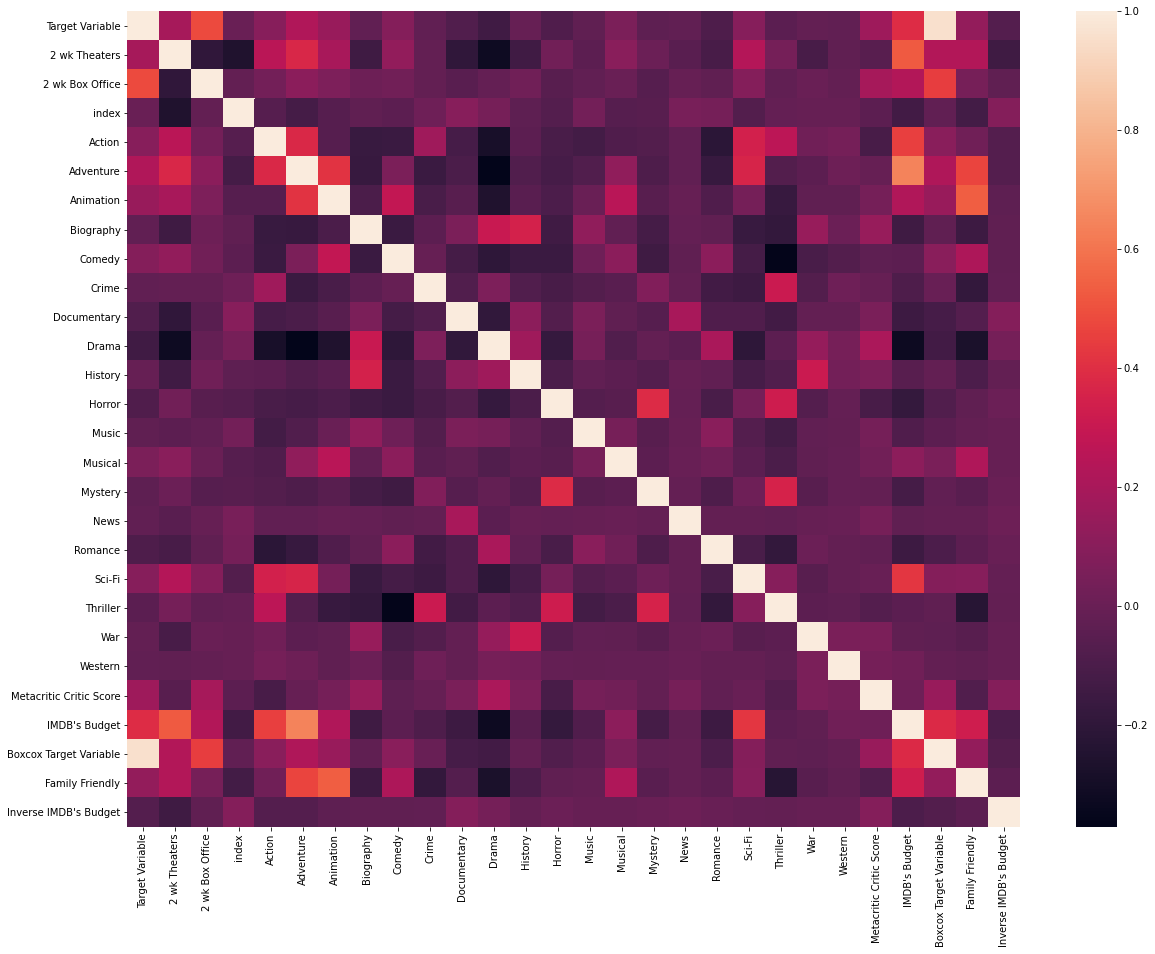

In [899]:
plt.subplots(figsize=(20, 15))
sns.heatmap(merged_clean.corr())

In [901]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()

scaled_df = pd.DataFrame(data=s.fit_transform(merged_clean), columns=merged_clean.columns)
base_features = scaled_df[scaled_df.columns[:-1]]
target_var = scaled_df["Boxcox Weeks Until Dropoff"]


from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(2)
p_features = pf.fit_transform(base_features)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(p_features, target_var, test_size=0.2, random_state=43)

In [902]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV()
ridge.fit(X_train, y_train)
print(ridge.score(X_train, y_train))
print(ridge.score(X_test, y_test))

0.989121014331023
0.9999998553758401


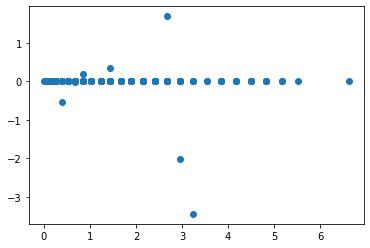

In [906]:
#!!!!!

from scipy.special import inv_boxcox
num_weeks_real = inv_boxcox(y_test, lamb)
num_weeks_estimated = inv_boxcox(ridge.predict(X_test), lamb)

residual_ = num_weeks_real-num_weeks_estimated
plt.scatter(y=residual_, x=num_weeks_real);

In [904]:
#I have about 200 items in the test set, and I can count the number of outliers. 


from sklearn.metrics import mean_absolute_error
mean_absolute_error(ridge.predict(p_features), target_var)

0.0034534065193297142